<a href="https://colab.research.google.com/github/GursimarSaini/INSE6310Project/blob/main/PredictiveMaintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INSE6310


In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import PCA


## Data Description

### The dataset consists of 10 000 data points stored as rows with 14 features in columns

##### UID: unique identifier ranging from 1 to 10000
##### product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
##### air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
##### process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
##### rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
##### torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
##### tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
##### 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.


###  The machine failure consists of five independent failure modes

##### tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
##### heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
##### power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
##### overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
##### random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

##### If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail



## justification for selecting this dataset

## AIM

## EDA

In [30]:
# Load data

df = pd.read_csv('https://raw.githubusercontent.com/GursimarSaini/INSE6310Project/main/data/ai4i2020.csv')

df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


In [31]:
# unique val
df.T.apply(lambda columns: columns.nunique(), axis=1)

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

In [32]:
# data type
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [33]:
# check null
df.isnull().any()

UDI                        False
Product ID                 False
Type                       False
Air temperature [K]        False
Process temperature [K]    False
Rotational speed [rpm]     False
Torque [Nm]                False
Tool wear [min]            False
Machine failure            False
TWF                        False
HDF                        False
PWF                        False
OSF                        False
RNF                        False
dtype: bool

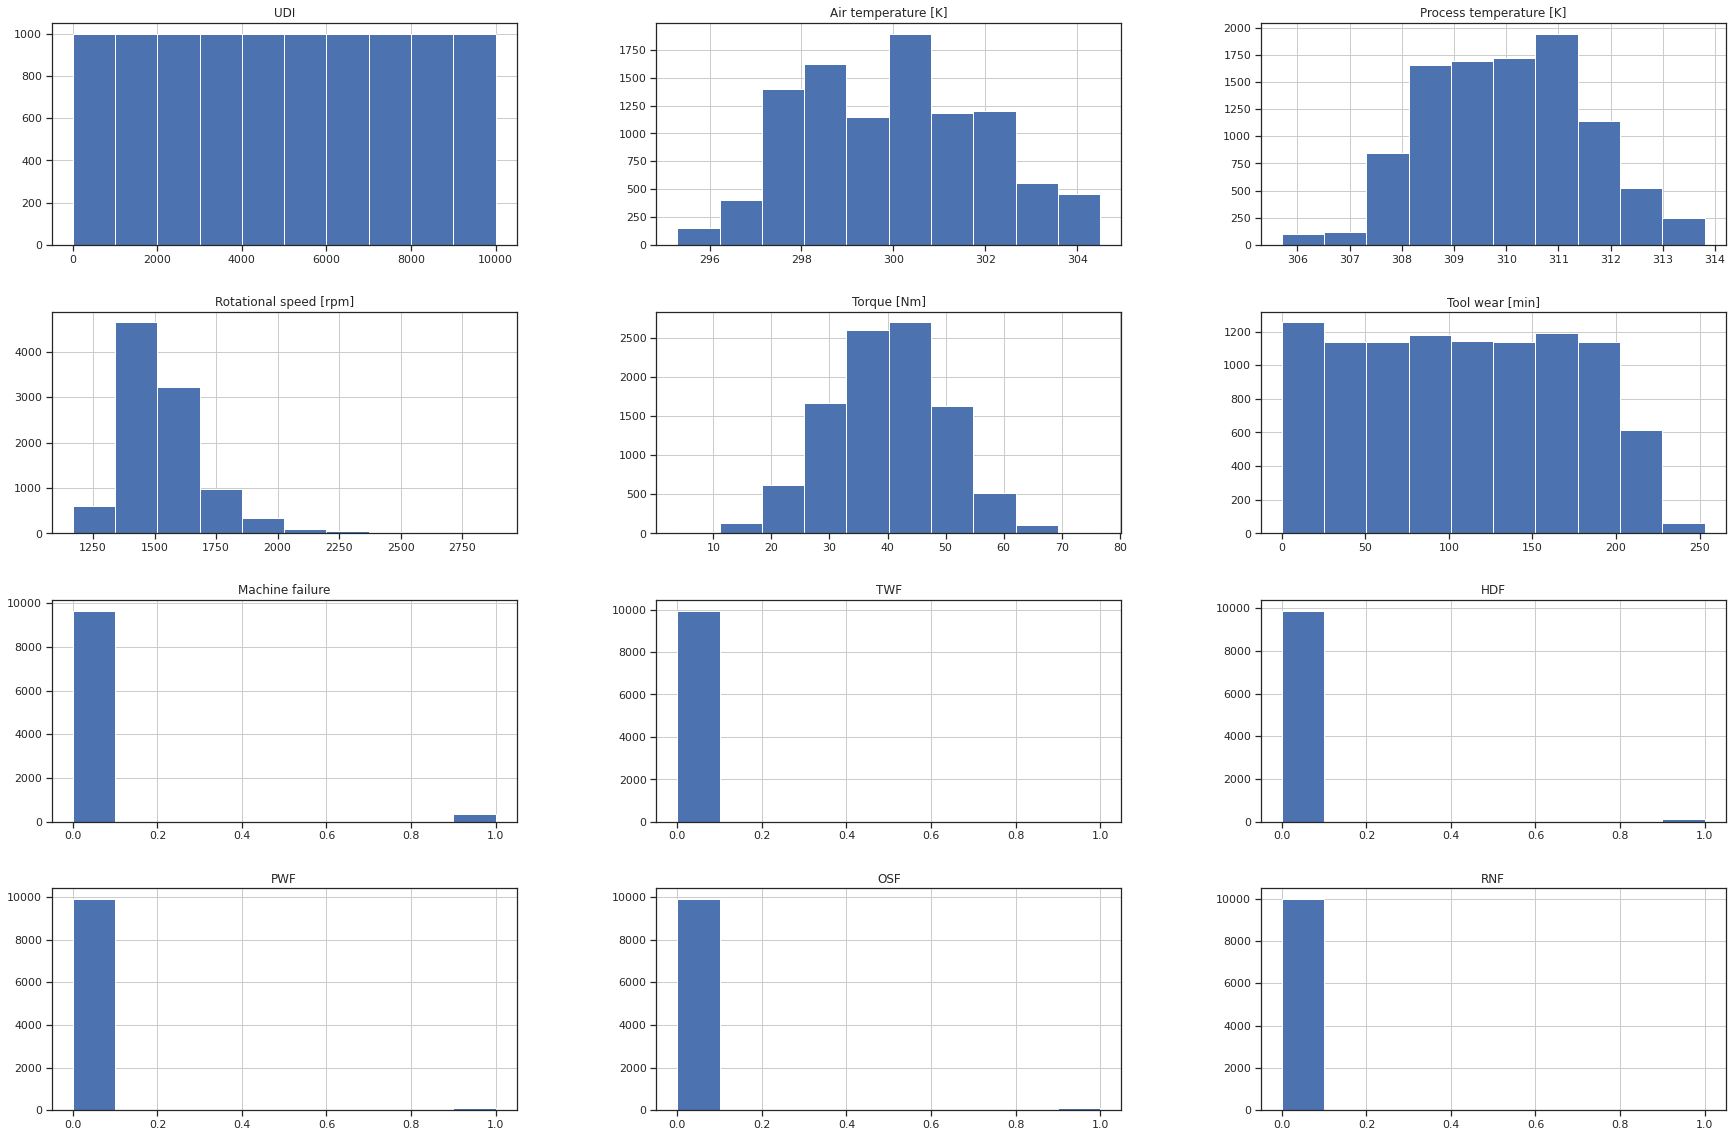

In [34]:
# univariate data exploration
df.hist(figsize=(30,20),grid = True);

Dropping extra columns

In [35]:
df = df.drop(columns=["UDI", "Product ID",	"Type"])

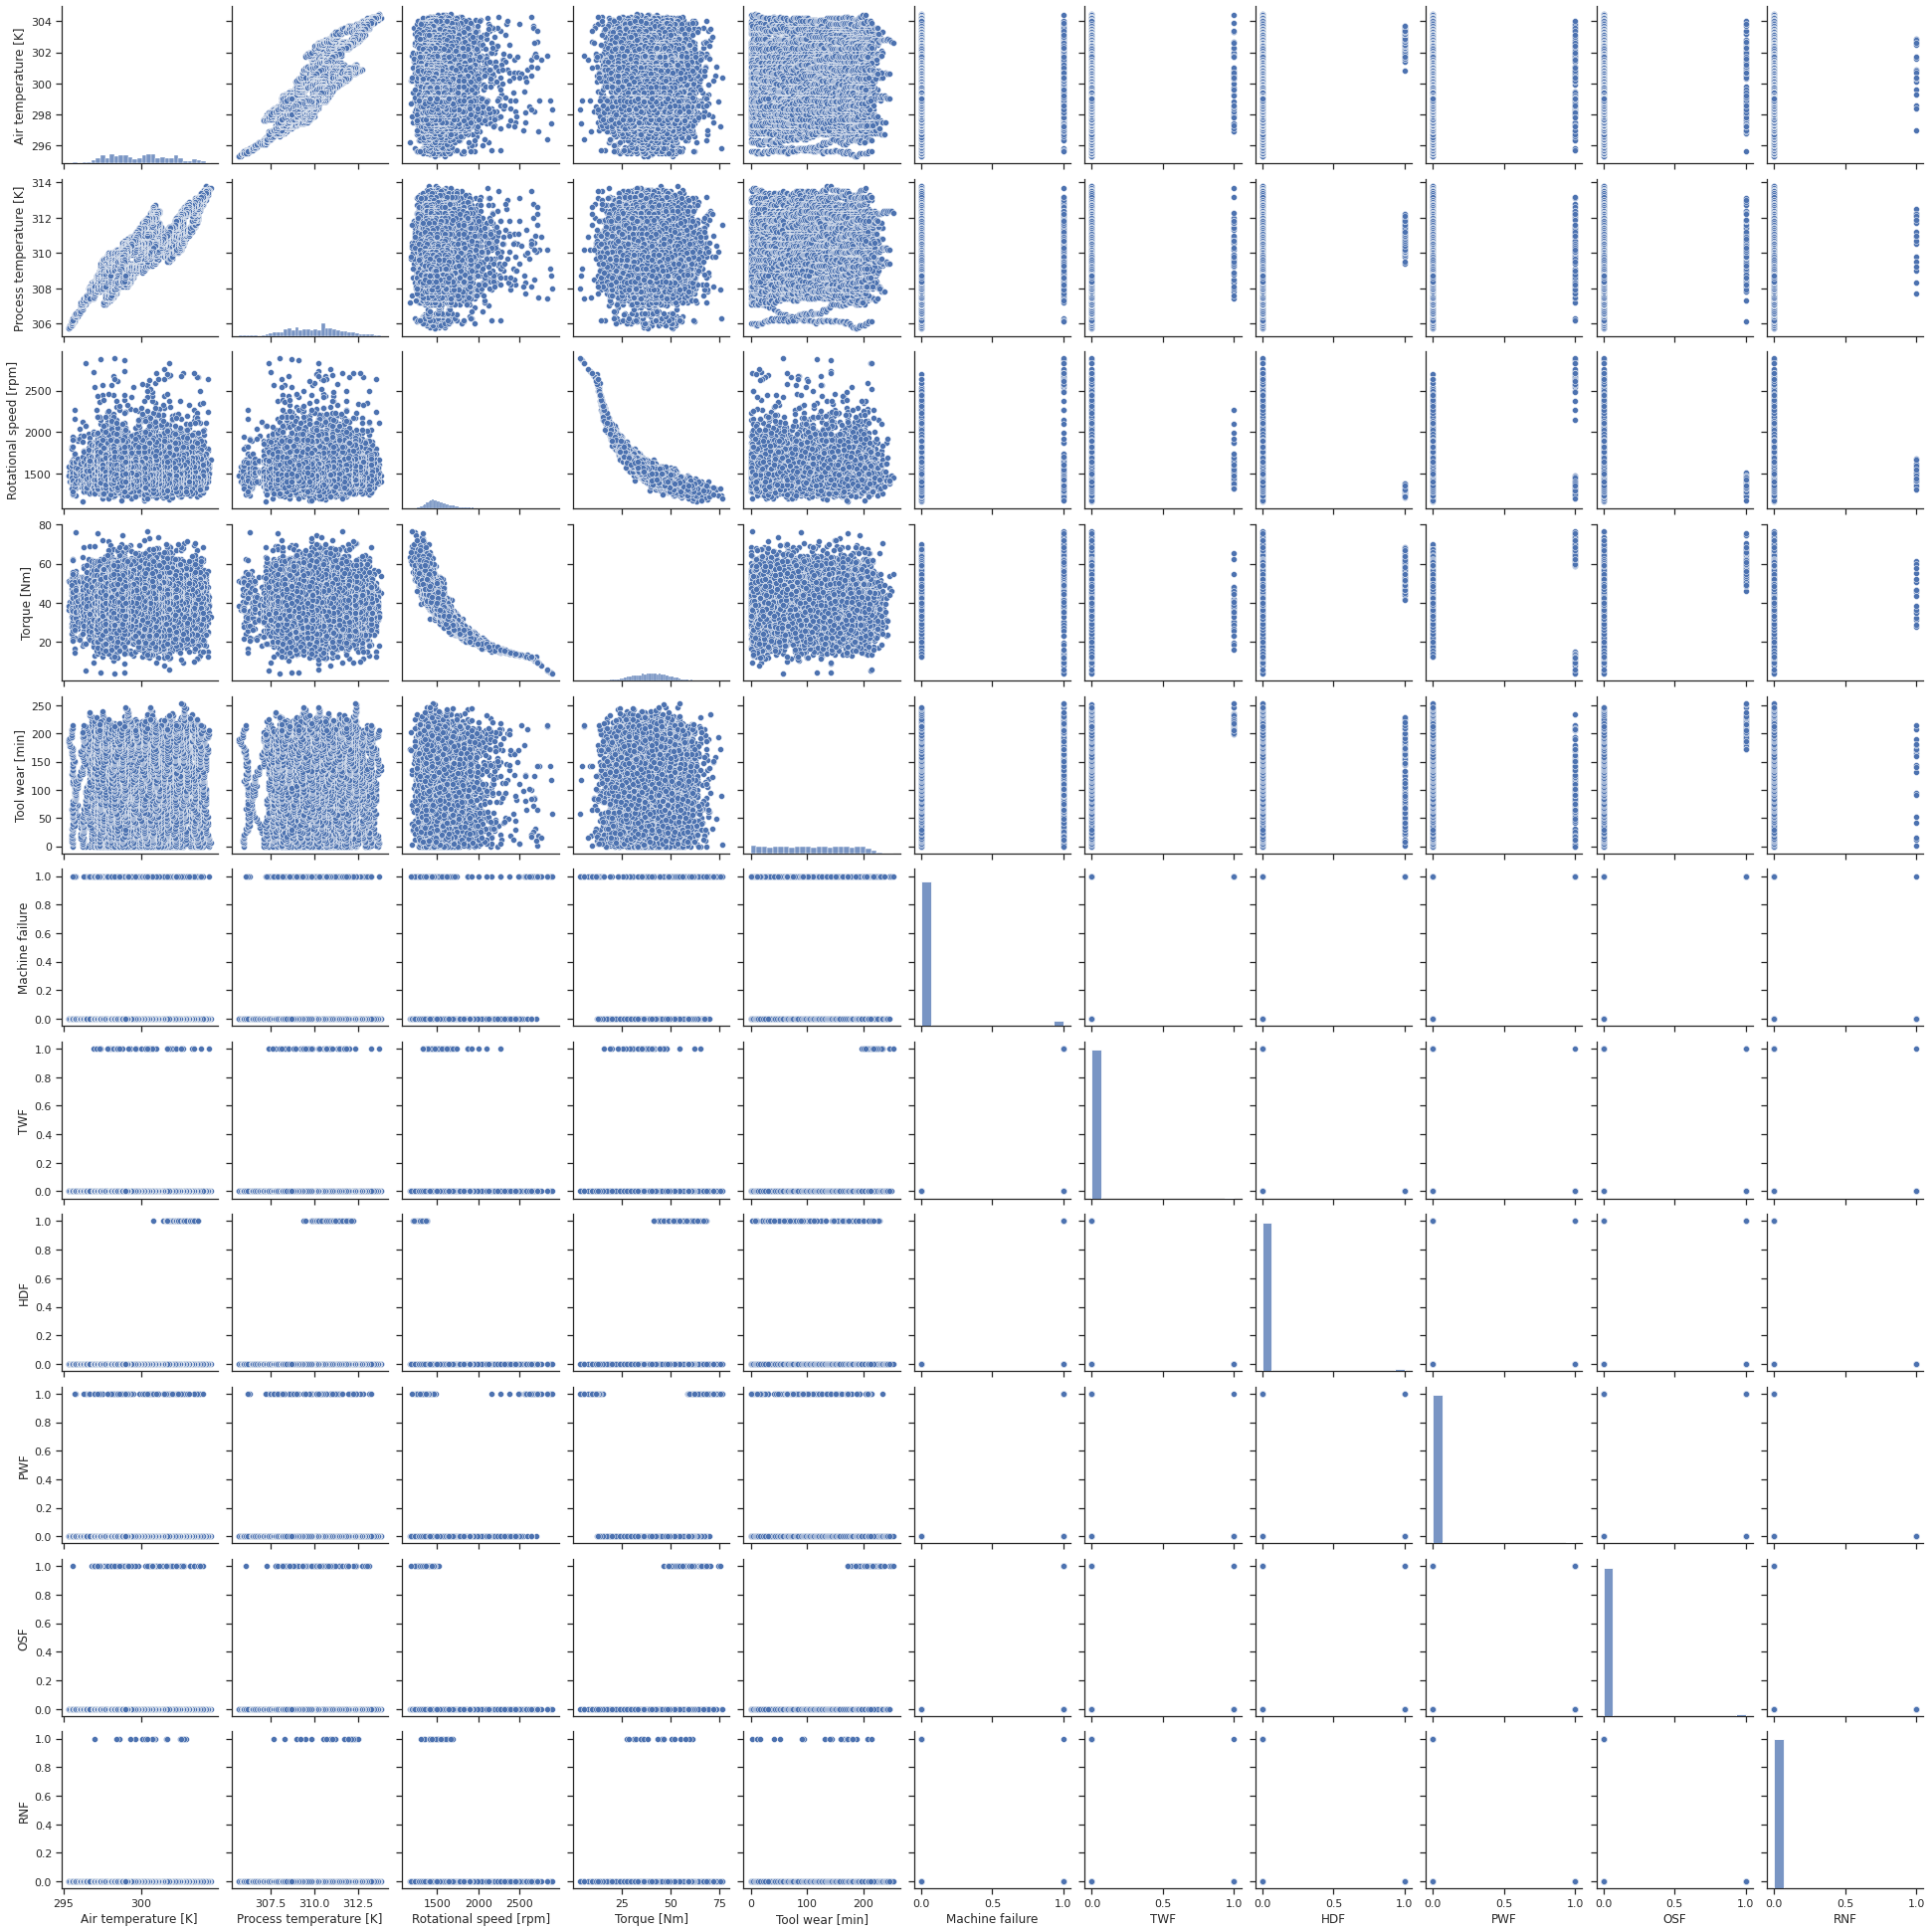

In [36]:
sns.pairplot(df)

#### ----- need more plots for TWF HDF PWF OSF RNF and more data exploration shit like box plot and comparison of failures among these categorties




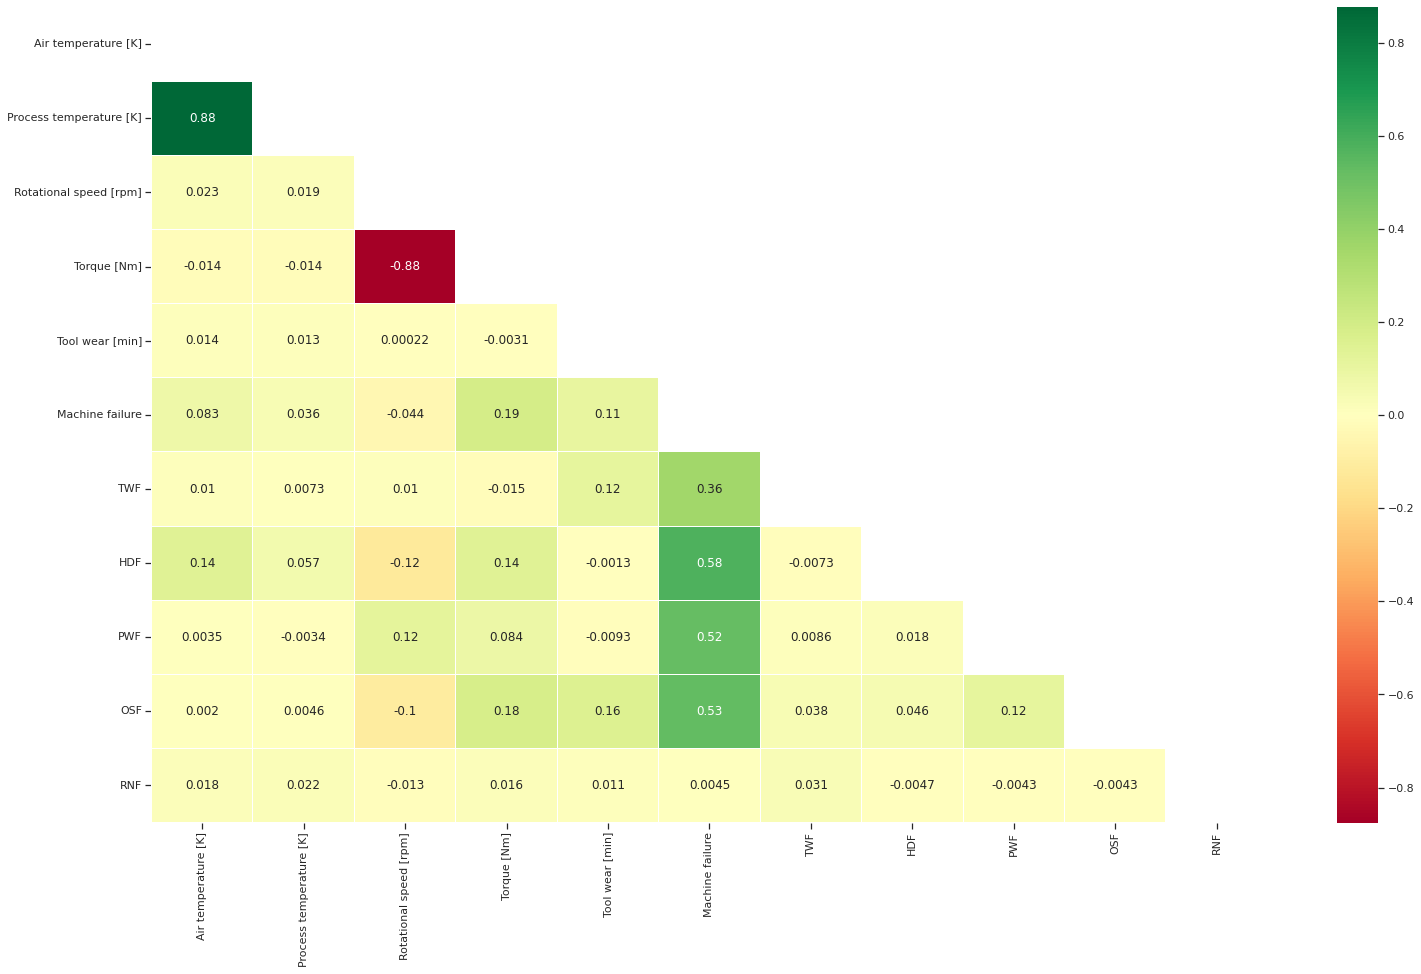

In [37]:
matrix = np.triu(df.corr())
plt.figure(figsize = (25, 15))
sns.heatmap(df.corr(), annot = True, linewidth = 0.02,cmap = 'RdYlGn', mask=matrix)
plt.show()

## Principal Component Analysis (PCA)

## scaling

In [38]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [39]:
scaler = StandardScaler()
scaler.fit(df)
Employee_scaled = scaler.transform(df)

## Modelling

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
y = df['Machine failure']
x = df.drop('Machine failure', axis = 1)

## Logistic regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X_train_lr,X_test_lr, y_train_lr, y_test_lr = train_test_split(x,y, test_size = 0.20, random_state=39)

X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.fit_transform(X_test_lr)
print(X_train_lr.shape,X_test_lr.shape)

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_lr,y_train_lr)
LR

yhat_LR = LR.predict(X_test_lr)
print(yhat_LR[0:5])
print(y_test_lr[0:5])

(8000, 10) (2000, 10)
[0 0 0 0 0]
9229    0
7476    0
2702    0
3941    0
3540    0
Name: Machine failure, dtype: int64
